In [1]:
# General Dependencies
import timeit, os
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose

# Plot & Video Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot, correlation_traces, snr_per_frame, nearest_frame_corr
from trefide.video import write_mpl, play_cv2

# Set Data Information
dataset = "Q-State Bio"
filename = os.path.join("..", "data", "prepared_sampleMovie.npy")

%load_ext autoreload
%autoreload 2

# Load Data & Set Params

In [2]:
mov = np.load(filename)
fov_height, fov_width, num_frames = mov.shape

In [3]:
max_components = 50
maxiter=50
consec_failures = 3
tol = 5e-3
block_height = 40
block_width = 40
spatial_cutoff = (block_height*block_width / ((block_height*(block_width-1) + block_width*(block_height-1))))
lambda_tv = .0025
overlapping = True

# Compress & Denoise

In [4]:
if not overlapping:
    # Perform Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    lambda_tv, spatial_cutoff,
                                    max_components,
                                    consec_failures,
                                    maxiter, tol)

    # Use Compressed Components To Reconstruct Denoise Video
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:
    # Perform 4x Overlapping Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                lambda_tv, spatial_cutoff,
                                                max_components,
                                                consec_failures,
                                                maxiter, tol)
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

success


In [5]:
import timeit
def time_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    lambda_tv, spatial_cutoff,
                                    max_components,
                                    consec_failures,
                                    maxiter, tol)

timeit.timeit(time_pmd, number=5)/5

10.109246231200085

# Produce Diagnostics

### Pixel-Wise Ranks

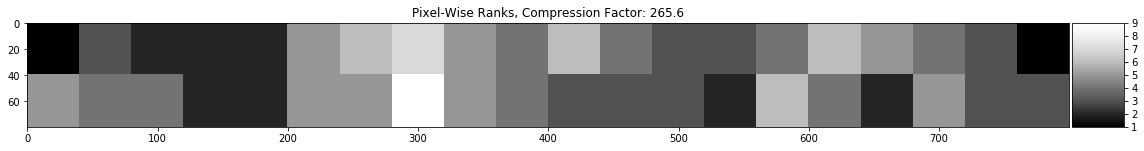

In [5]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Traces

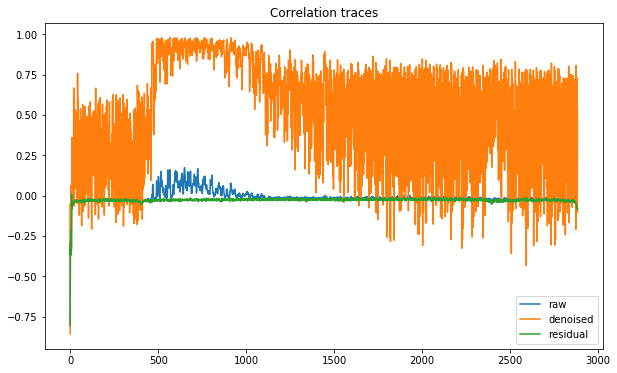

In [6]:
correlation_traces(mov, mov_denoised, mov - mov_denoised)
plt.show()

### Correlation Images

Local correlation:  range [-2.8e-02 5.2e-01]
Local correlation:  range [-1.0e+00 1.0e+00]
Local correlation:  range [-7.0e-02 9.9e-02]


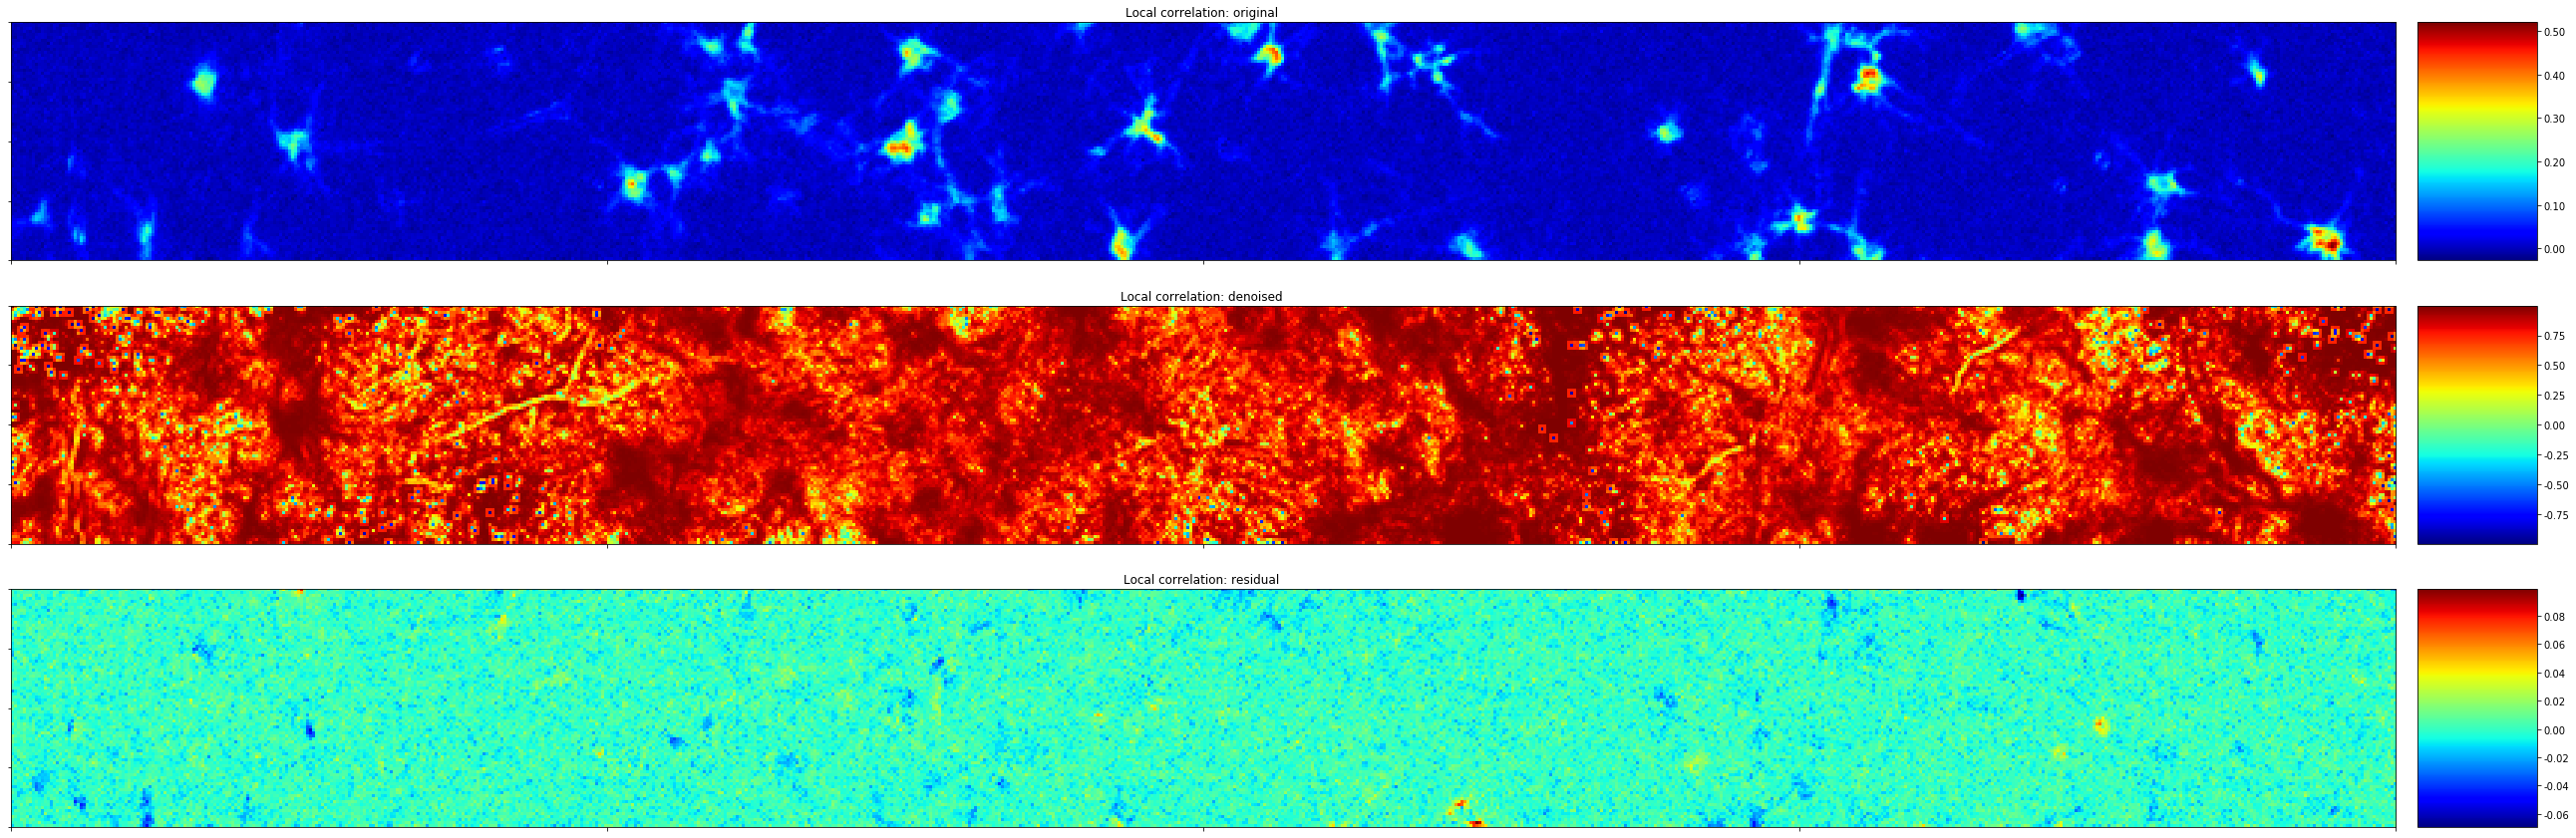

In [7]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

## Videos

### Render With OpenCV3

In [ ]:
play_cv2(np.vstack([Y, Yd, Y - Yd]), magnification=2)

### Write With MPL Formatting

In [12]:
write_mpl(mov_list=[mov, mov_denoised, mov - mov_denoised], filename=dataset, fr=60, horizontal=False)